In [98]:
import bertviz
import torch

from transformers import BertTokenizer, BertModel
from pprint import pprint
from bertviz import head_view, model_view
from typing import Tuple
from typing import List, Optional

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import csgraph
from scipy.sparse import csr_matrix

In [99]:
# attention -> tuple len of num layers of (batch_size, num_heads, seq_len, seq_len)

def get_num_layers(attention):
    return len(attention)

def get_num_heads(attention):
    # first layer, first batch element
    return attention[0][0].size(0)

def format_attention(attention, layers=None, heads=None):
    if layers:
        attention = [attention[layer_index] for layer_index in layers]
    squeezed = []
    for layer_attention in attention:
        # print(layer_attention.shape)
        # 1 x num_heads x seq_len x seq_len
        if len(layer_attention.shape) != 4:
            raise ValueError("The attention tensor does not have the correct number of dimensions. Make sure you set "
                             "output_attentions=True when initializing your model.")
        layer_attention = layer_attention.squeeze(0)
        if heads:
            layer_attention = layer_attention[heads]
        squeezed.append(layer_attention)
    # num_layers x num_heads x seq_len x seq_len
    return torch.stack(squeezed)

In [100]:

def plot_barcodes(attention: Tuple, layer: int = 0, head: int = 0, plot_heatmap: bool = True, tokens: Optional[List] = None):
    f_attention = format_attention(attention)
    f_attention = f_attention.detach().numpy()

    graph = 1 - f_attention[layer, head]

    if plot_heatmap:
        if tokens is None:
            tokens = 'auto'
        sns.heatmap(graph, annot=True, cmap='viridis', fmt=".2f", xticklabels=tokens, yticklabels=tokens)
        plt.title('Attention Matrix')
        plt.show()
    
    # flatten graph and sort
    thresholds = sorted(graph.reshape(-1).tolist())
    # print(thresholds)

    used_thresholds = []
    n_connected_components = []
    
    for threshold in thresholds:
        adjacency_matrix = graph <= threshold
        sparse_matrix = csr_matrix(adjacency_matrix)
        n_components, labels = csgraph.connected_components(sparse_matrix)

        used_thresholds.append(threshold)
        n_connected_components.append(n_components)

        if n_components == 1:
            used_thresholds[-1] = 1
            break

    # print(used_thresholds)
    # print(n_connected_components)

    fig, ax = plt.subplots()
    ax.barh(n_connected_components, used_thresholds) #, align='center')

    ax.set_xlabel('Thresholds')
    ax.set_ylabel('N connected components')
    ax.set_title('Barcodes')

    plt.show()

In [101]:
def get_attentions(model, tokenizer, text, debug: bool = True, return_tokens: bool = False):
    # token_type_ids
    encoded_input = tokenizer(text, return_tensors='pt')

    debug and print(encoded_input.keys())
    debug and pprint(encoded_input)

    input_ids = encoded_input['input_ids']

    debug and print(input_ids.shape)

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0]) 

    debug and print(tokens)

    with torch.no_grad():
        output = model(**encoded_input)
        attention = output['attentions']
        debug and print(attention)
    
    if return_tokens:
        return attention, tokens
    else:
        return attention

In [102]:
# Output attentions = TRUE
model = BertModel.from_pretrained("bert-base-uncased", output_attentions=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

text = "I love you"

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [103]:
attention, tokens = get_attentions(model, tokenizer, text, debug=False, return_tokens=True)
attention

(tensor([[[[1.2942e-01, 1.0966e-01, 7.6772e-02, 8.0205e-02, 6.0394e-01],
           [2.8612e-01, 2.0097e-01, 2.3074e-01, 1.5231e-01, 1.2986e-01],
           [3.4637e-01, 1.7007e-01, 1.1124e-01, 1.1922e-01, 2.5310e-01],
           [2.4026e-01, 2.9431e-01, 1.6572e-01, 1.3948e-01, 1.6025e-01],
           [1.8692e-01, 1.7019e-01, 1.3924e-01, 1.5884e-01, 3.4482e-01]],
 
          [[9.5996e-01, 2.2468e-02, 4.5803e-03, 5.4822e-03, 7.5143e-03],
           [2.5183e-02, 6.5255e-02, 7.1472e-01, 7.1696e-02, 1.2314e-01],
           [7.5605e-02, 3.2710e-02, 4.2541e-01, 8.5231e-02, 3.8104e-01],
           [1.7483e-02, 9.0004e-03, 8.5426e-01, 1.7040e-02, 1.0221e-01],
           [9.7334e-02, 4.6377e-01, 1.2675e-01, 2.1486e-01, 9.7285e-02]],
 
          [[8.5451e-01, 3.4337e-02, 2.5631e-02, 2.9076e-02, 5.6444e-02],
           [8.0306e-01, 7.6158e-02, 2.3546e-02, 3.4475e-02, 6.2763e-02],
           [6.6197e-02, 8.6942e-01, 1.5092e-02, 3.8517e-02, 1.0768e-02],
           [2.6756e-01, 9.3326e-02, 5.4577e-0

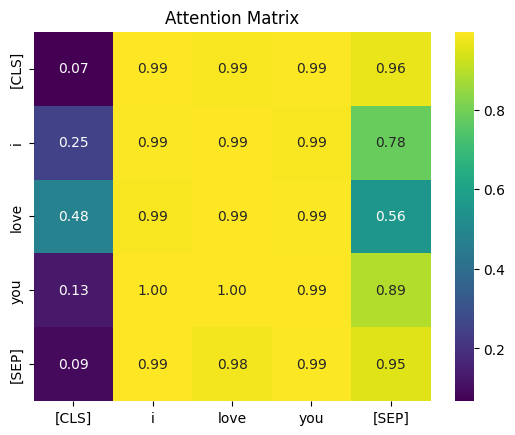

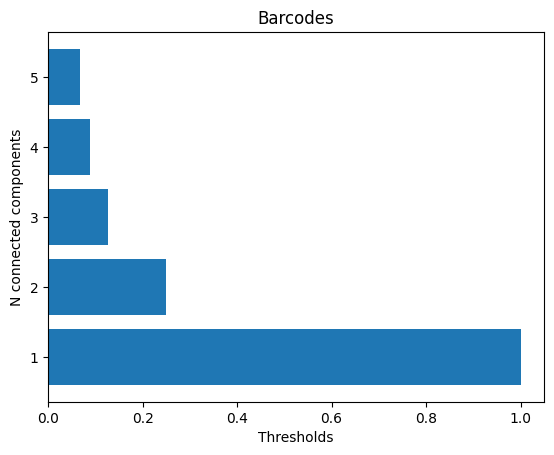

In [104]:
plot_barcodes(attention, 1, 6, tokens=tokens)

In [105]:
model_view(attention, tokens)
head_view(attention, tokens, heads=[6])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1. Веса внимания (1-вес)
2. Упорядочиваем получившиеся веса по возрастанию
3. Начинаем по одному добавлять, начиная с самого маленького

In [106]:
#  !pip install git+https://github.com/ArGintum/RipserZeros.git

def rtd(a, b, dim=1, mode='max'):
  # Parameters:
  #           a    - adjacency matrix (symmetric) of the first graph
  #           b    - adjacency matrix (symmetric) of the first graph
  #           dim  - dimension of RTD. Default: 1 (in all our experiments we used this value only)
  #           mode - variant of RTD to use. Default: 'max' (in all our experiments we used this value only)

  # Returns: list of bars of RTD(, ) in dimension 

  if mode != 'max' and mode != 'min':
     raise ValueError("Wrong Value for 'mode' parameter. RTD mode can be either 'min' or 'max' ")

  n = a.shape[0]
  d = np.zeros((2 * n, 2 * n))
  
  if mode == 'max':
    d[n:, :n] = torch.maximum(a.cpu(), b.cpu()).detach().numpy()  
    d[:n, n:] = torch.maximum(a.cpu(), b.cpu()).detach().numpy()  
    d[n:, n:] = b.cpu().detach().numpy()
  else:
    d[n:, :n] = a.cpu().detach().numpy()
    d[:n, n:] = a.cpu().detach().numpy()
    d[n:, n:] = torch.minimum(a.cpu(), b.cpu()).detach().numpy() 

  m = d[n:, :n].mean()
  d[d < m*(1e-6)] = 0
  results = rpp_py.run("--format distance --mode rtd --dim " + str(dim), d)['dgms'][dim]
  return results
